In [1]:
%matplotlib inline

In [2]:
import os, sys, math, random
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

К сожалению, на это задание у меня был всего один день. Послушать лекции про GANы и не попробовать их в рамках курса на мой взгляд было бы большим преступлением, поэтому я решил попытаться успеть сделать хотя бы pix2pix.

# Advanced DL and RL: Домашнее задание 3
Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое задание в курсе, самое техническое и вообще необязательное (дополнительное), но что уж поделать. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: перенос стиля при помощи pix2pix

### Чтение данных

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
TRAIN_FOLDER = './facades/train/'
TEST_FOLDER = './facades/test/'
VAL_FOLDER = './facades/val/'

In [6]:
def get_images(folder):
    return list(map(str, Path(folder).rglob('*.jpg')))

train_images = get_images(TRAIN_FOLDER)

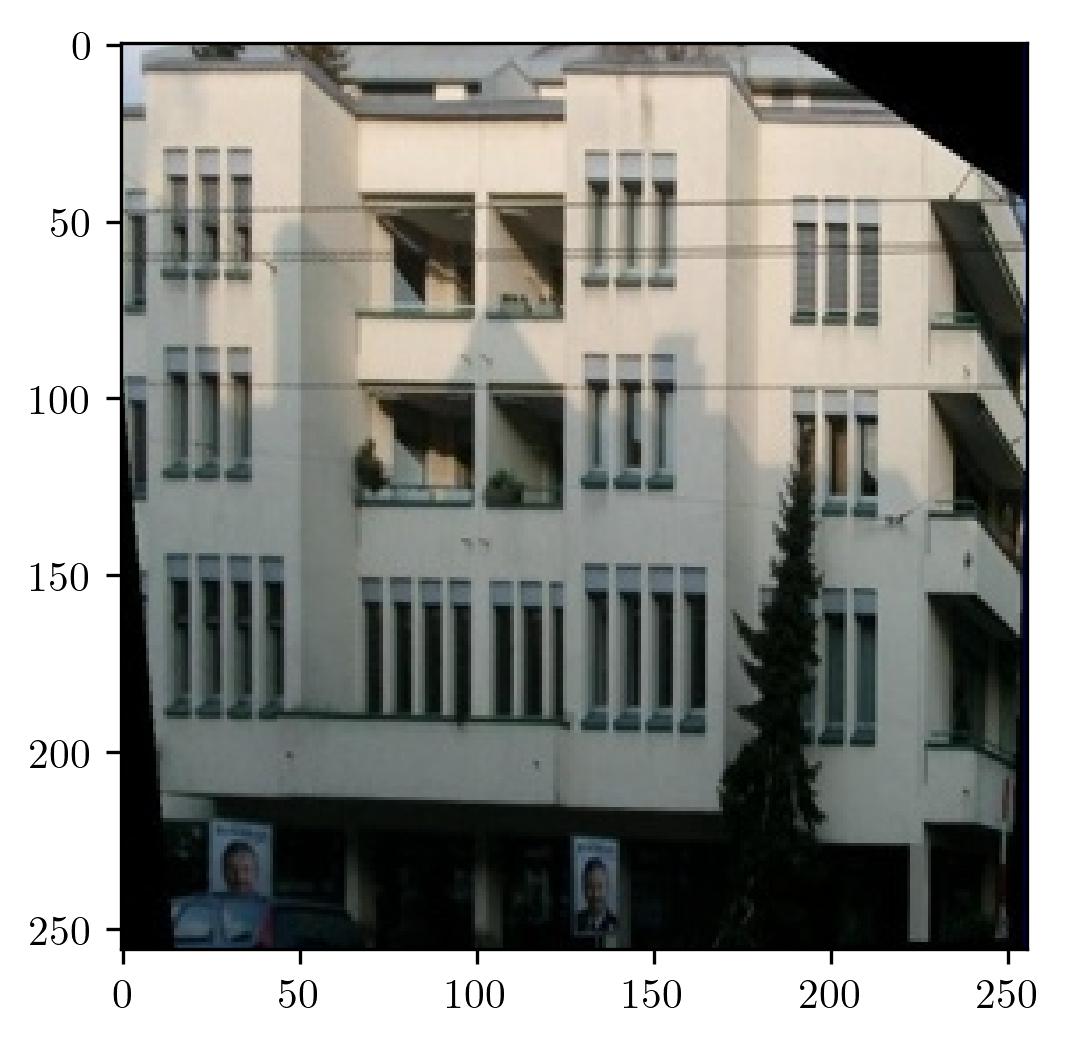

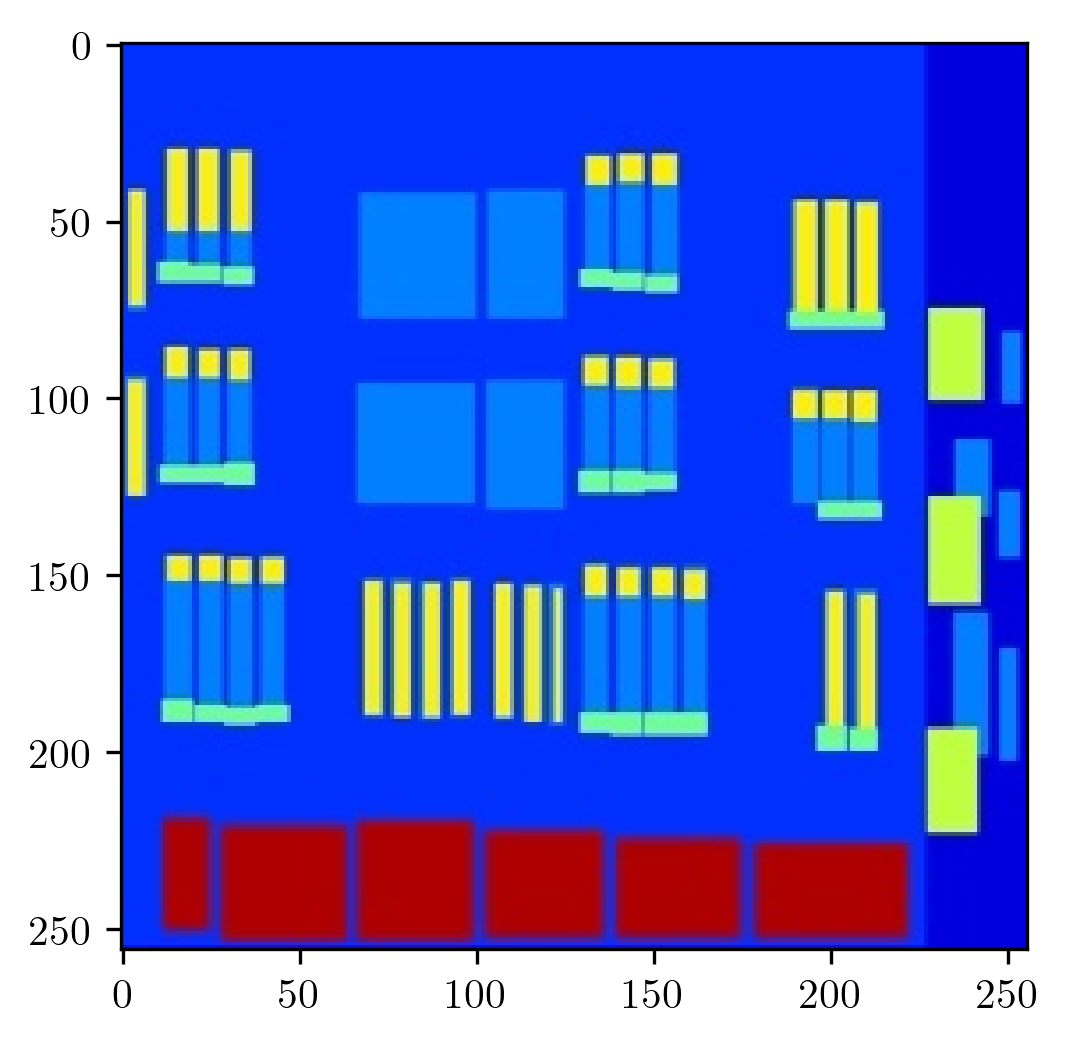

In [7]:
import cv2

class PairedDataset(Dataset):
    def __init__(self, images, transforms_image=None, transforms_mask=None):
        super().__init__()
        self.images = images
        self.transforms_image = transforms_image
        self.transforms_mask = transforms_mask
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Читаем изображение и фиксим цветовую гамму
        image = cv2.imread(self.images[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Разрезаем изображение на два
        image_result = image[:, :image.shape[1]//2, :]
        image_mask = image[:, image.shape[1]//2:, :]
        
        # Обрабатываем изображение с помощью трансформаций
        if self.transforms_image:
            image_result = self.transforms_image(image_result)
            
        # Обрабатываем маску с помощью трансформаций
        if self.transforms_mask:
            image_mask = self.transforms_mask(image_mask)
            
        return image_result, image_mask
        
        
d = PairedDataset(get_images(TRAIN_FOLDER))
image_result, image_mask = d[0]
plt.imshow(image_result)
plt.show()
plt.imshow(image_mask)
plt.show()

### Опишем наборы данных

In [9]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
    
train_dataset = PairedDataset(get_images(TRAIN_FOLDER), transforms_image=image_transforms, transforms_mask=mask_transforms)
test_dataset = PairedDataset(get_images(TEST_FOLDER), transforms_image=image_transforms, transforms_mask=mask_transforms)
val_dataset = PairedDataset(get_images(VAL_FOLDER), transforms_image=image_transforms, transforms_mask=mask_transforms)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, drop_last=True, num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, num_workers=4)

In [10]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

### Генератор

В качестве генератора я решил взять обычную UNet архитектуру в EfficientNet-B0 в качестве backbone. Думаю, что для задания это в целом не принципиально, поэтому воспользовался готовым модулем.

In [11]:
import segmentation_models_pytorch as smp

### Дискриминатор

В качестве дискриминатора в данной архитектуре предлагается взять PatchGAN. Это обычная сверточная сеть, которая на финальном сверточном слое просто предсказывает набор вероятностей для отдельных патчей из изображения. Авторы предлагают не очень сложную архитектуру, которую я постарался реализовать ниже.

Я выбрал архитектуру, у которой На финальном слое рецептивное поле отдельного пикселя - это патч величины 70x70.

In [13]:
class PatchGANDiscriminator(nn.Module):
    def __init_weights__(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        elif type(m) == nn.Conv2d:
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
    
    def __init__(self):
        super().__init__()

        self.c64 = nn.Sequential(
            nn.ConstantPad2d((1, 1, 1, 1), 0.0),
            nn.Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2)),
            nn.LeakyReLU(0.2)
        )
        
        self.c128 = nn.Sequential(
            nn.ConstantPad2d((1, 1, 1, 1), 0.0),
            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.c256 = nn.Sequential(
            nn.ConstantPad2d((1, 1, 1, 1), 0.0),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        self.c512 = nn.Sequential(
            nn.ConstantPad2d((1, 1, 1, 1), 0.0),
            nn.Conv2d(256, 512, kernel_size=(4, 4)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self.output = nn.Sequential(
            nn.ConstantPad2d((1, 1, 1, 1), 0.0),
            nn.Conv2d(512, 1, kernel_size=(4, 4)),
            nn.Sigmoid()
        )
        
        self.apply(self.__init_weights__)
        
    def forward(self, image_real, image_mask):
        # Concatenate real image and its mask
        image_concat = torch.cat([image_real, image_mask], dim=1)
        x = self.c64(image_concat)
        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        x = self.output(x)
        return x
        
# a = next(iter(train_dataloader))
# discriminator = PatchGANDiscriminator()
# discriminator(*a)

# Цикл обучения

In [23]:
def train_step(generator_info, discriminator_info, condition_images, condition_masks, real_images, real_masks):
    # Распаковываем информацию о генераторе
    generator, optimizer_generator = generator_info
    
    # Распаковываем информацию о дискриминаторе
    discriminator, optimizer_discriminator = discriminator_info
    
    # Обучаем генератор
    optimizer_generator.zero_grad()
    
    # Порождаем фейковые картинки
    gen_images = generator(condition_masks)
    
    # Пропускаем фейковые картинки через дискриминатор
    discriminator_fake_predictions = discriminator(gen_images, condition_masks)
    # Получаем целевые переменные для настоящих и фейковых изображений
    valid = torch.ones_like(discriminator_fake_predictions, requires_grad=False)
    fake = torch.zeros_like(discriminator_fake_predictions, requires_grad=False)
    
    # Объявляем loss
    adversarial_loss = nn.BCELoss().to(valid.device)
    l1_loss = nn.L1Loss().to(device)
    
    # Считаем лосс для дискриминатора
    g_loss = adversarial_loss(discriminator_fake_predictions, valid) + 10.0 * l1_loss(gen_images, condition_images) # Для лучшего обучения необходимо давать L1 больший вес. Без этого сходимость была хуже
    g_loss.backward()
    optimizer_generator.step()
    
    # Обучаем дискриминатор
    optimizer_discriminator.zero_grad()
    # Считаем функции потерь для настоящих и фейковых картинок
    real_loss = adversarial_loss(discriminator(real_images, real_masks), valid)
    fake_loss = adversarial_loss(discriminator(gen_images.detach(), condition_masks), fake)
    d_loss = (real_loss + fake_loss) / 4 # Вроде как в статье говорят, что берут в качестве лосса для дискриминатора D/2
    d_loss.backward()
    optimizer_discriminator.step()
    
    return gen_images, d_loss, g_loss

In [25]:
def train(generator_info, discriminator_info, dataset_condition, dataset_real, generate_every=10, generate_dir='./data_b0', num_epochs=1):
    g_losses, d_losses = [], []
    batches_done = 0
    for epoch in range(num_epochs):
        for i, (real_images, real_masks) in enumerate(dataset_real):
            # Переносим все на устройство
            real_images = real_images.to(device)
            real_masks = real_masks.to(device)
            
            gen_imgs, d_loss, g_loss = train_step(generator_info, discriminator_info, real_images, real_masks, real_images, real_masks)
            batches_done += 1
            
            if d_loss is not None and g_loss is not None:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
            
            if batches_done % generate_every == 0:
                print("\t...epoch %d\tbatch %d\tD loss: %.6f\tG loss: %.6f" % (epoch, num_epochs, d_losses[-1], g_losses[-1]))
                gen_imgs = inv_normalize(gen_imgs)
                save_image(gen_imgs.data[:8], "%s/%05d.png" % (generate_dir, batches_done), nrow=2, normalize=False)

In [16]:
# Генератор
generator = smp.Unet(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
).to(device)
generator.train()

# Дискриминатор
discriminator = PatchGANDiscriminator(
).to(device)
discriminator.train()

# Оптимизаторы
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

В начале обучения я посовершал глупых ошибок - для генератора использовал валидационные данные, а для дискриминатора - тренировочные. Сперва мне это казалось логичным, поскольку генератор не видел бы все данные, а работал на какой-то отдельной входной conditional-выборке. Из-за этого как мне кажется все сходилось достаточно плохо, эти результаты я не стал сюда прикладывать. На мой взгяд обучалось плохо именно из-за того, что валидационных данных всего 100 изображений, а тренировочных - 400 изображений. Для генератора в этой ситуации было достаточно мало данных, поэтому ему плохо удавалось ловить общие зависимости.

Также сперва я пробовал брать разные размеры батча - 8, 32. Но в итоге почитав, как обучают эту архитектуру, увидел, что берут размер батча, равный 1.

Однако веса, полученные в том обучении я все-таки подгрузил и решил начать с них

In [17]:
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [19]:
discriminator.load_state_dict(torch.load('discriminator.pth'))

<All keys matched successfully>

In [26]:
train(
    (generator, optimizer_generator),
    (discriminator, optimizer_discriminator),
    val_dataloader,
    train_dataloader,
    generate_every=500,
    num_epochs=10000
)

	...epoch 1	batch 10000	D loss: 0.003556	G loss: 14.960468
	...epoch 2	batch 10000	D loss: 0.068289	G loss: 8.964205
	...epoch 3	batch 10000	D loss: 0.831379	G loss: 12.671811
	...epoch 4	batch 10000	D loss: 0.103755	G loss: 11.920582
	...epoch 6	batch 10000	D loss: 0.049887	G loss: 12.706615
	...epoch 7	batch 10000	D loss: 0.021222	G loss: 13.041454
	...epoch 8	batch 10000	D loss: 0.053036	G loss: 12.889172
	...epoch 9	batch 10000	D loss: 0.015994	G loss: 11.518135
	...epoch 11	batch 10000	D loss: 0.091451	G loss: 9.168133
	...epoch 12	batch 10000	D loss: 0.027414	G loss: 15.776079
	...epoch 13	batch 10000	D loss: 0.547167	G loss: 8.314510
	...epoch 14	batch 10000	D loss: 0.070226	G loss: 12.861907
	...epoch 16	batch 10000	D loss: 0.039350	G loss: 11.621367
	...epoch 17	batch 10000	D loss: 0.000560	G loss: 16.295408
	...epoch 18	batch 10000	D loss: 0.023380	G loss: 12.820333
	...epoch 19	batch 10000	D loss: 0.008466	G loss: 14.447593
	...epoch 21	batch 10000	D loss: 0.012842	G loss: 1

KeyboardInterrupt: 

В целом, на мой субъективный взгляд, результаты получились не самыми плохими для одного дня. Модель обучалась несколько часов.
Из недостатков видно, что на части изображений есть проблемы на краях (они либо слишком светлые, либо слишком темные, результаты можно увидеть в папке `data_b0`). К сожалению, на этот вопрос у меня нет четкого ответа.

Возможно, архитектура моего генератора была слишком простой и стоило брать другой backbone (это я попытался все-таки сделать, но Colab работает не так быстро, как хотелось бы).

Что еще я не учел из важных вещей - это постепенное уменьшение lr. Как я понял, одна из возможных стратегий - это оставлять lr постоянным какое-то количество эпох, а после линейно уменьшать до нуля (примеры стратегий уменьшения lr можно найти [здесь](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py#L31)).

In [27]:
torch.save(generator.state_dict(), 'generator_unet_effnb0.pth')

In [28]:
torch.save(discriminator.state_dict(), 'discriminator_patchgan_70x70.pth')

Загенерируем картинки на тесте

In [51]:
generator.load_state_dict(torch.load('generator_unet_effnb0.pth'))

<All keys matched successfully>

В статье написано, что поскольку они не используют шум для генерации, они не отключают dropout на inference, тем самым добиваясь хоть какой-то вариативности. Также при применении они используют batch-norm статистики от test batch'а. В данной ситуации я перевел модель в обычный режим применения, поскольку после применения результаты плыли по изображениям в процессе применения (чем больше мы изображений загенерировали, тем хуже)

In [ ]:
generator = generator.eval()

In [48]:
from IPython.display import display

In [56]:
from PIL import Image

In [57]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

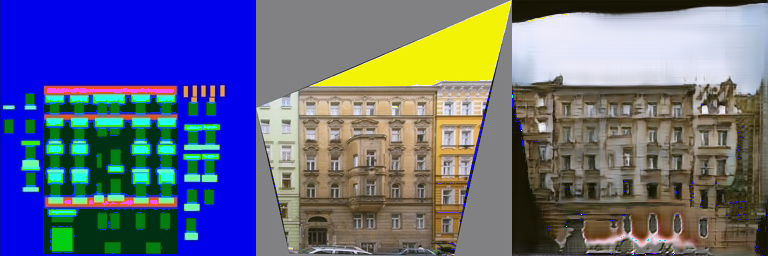

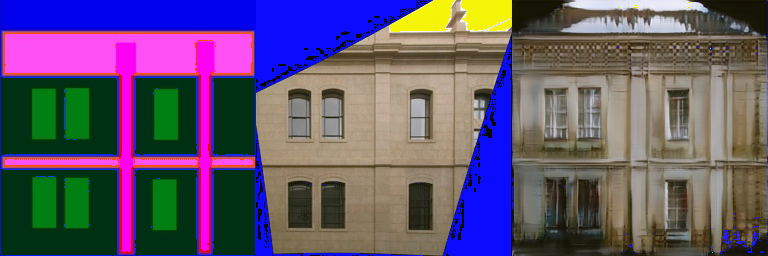

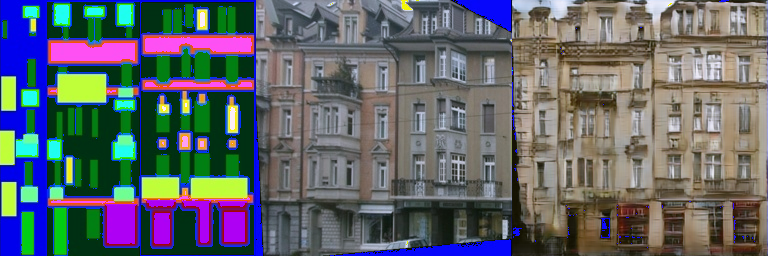

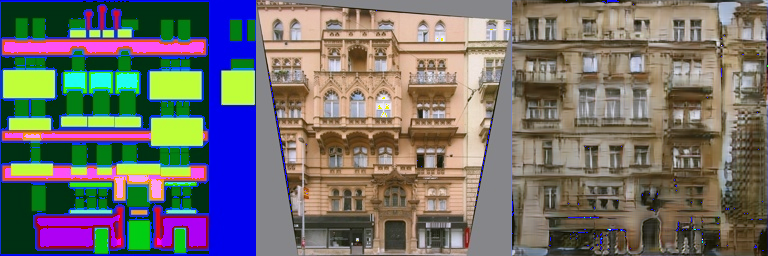

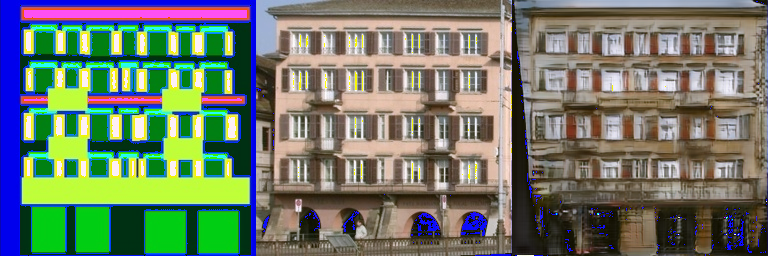

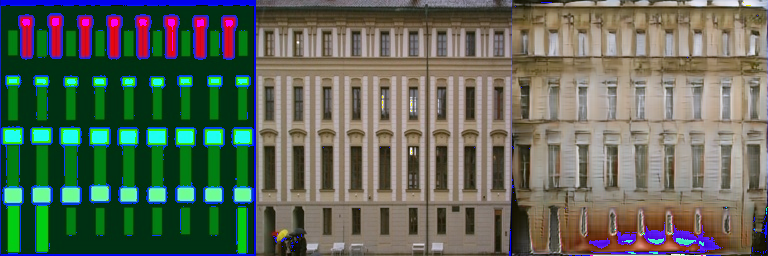

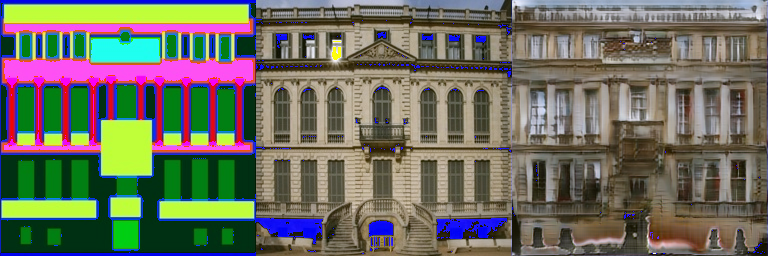

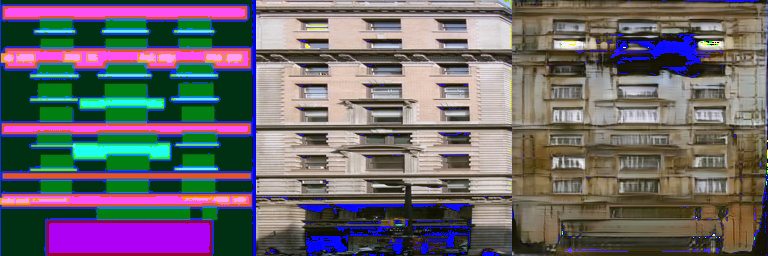

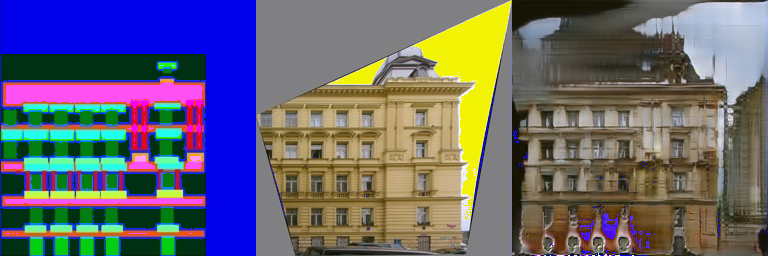

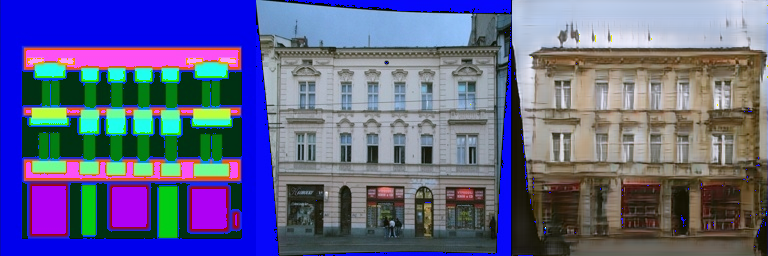

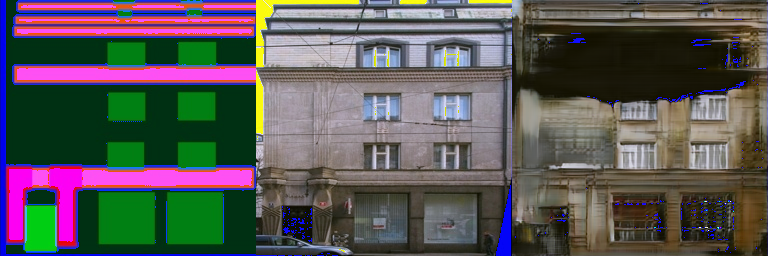

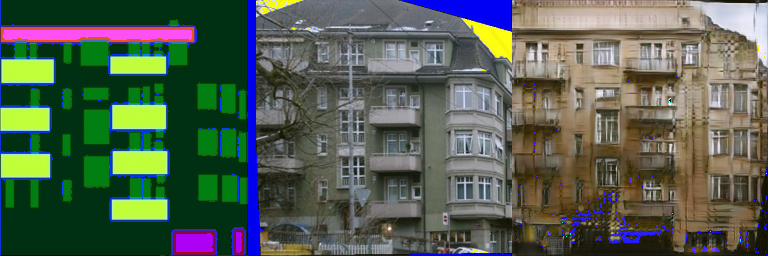

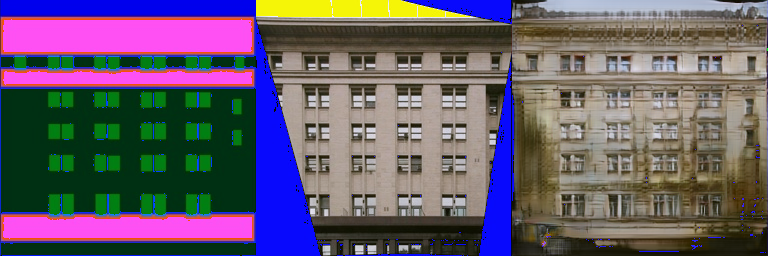

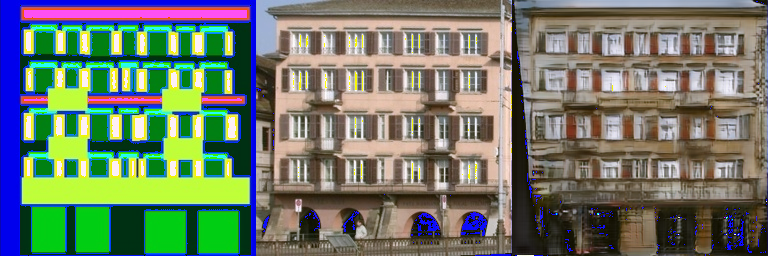

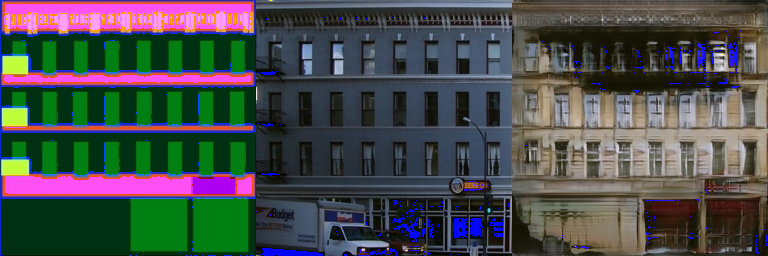

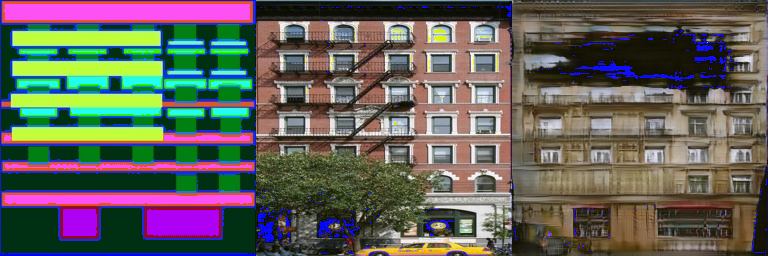

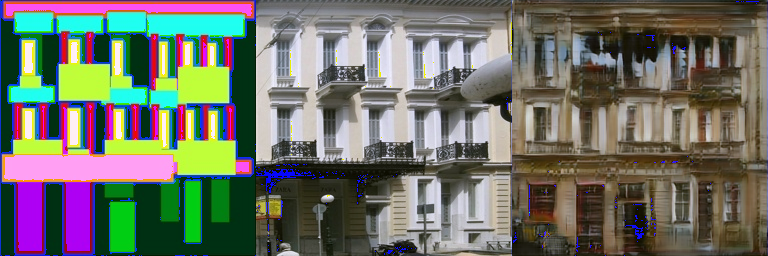

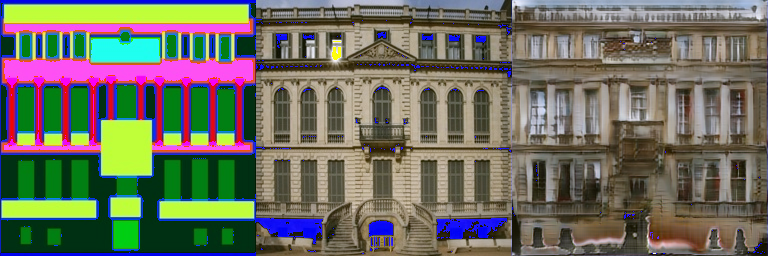

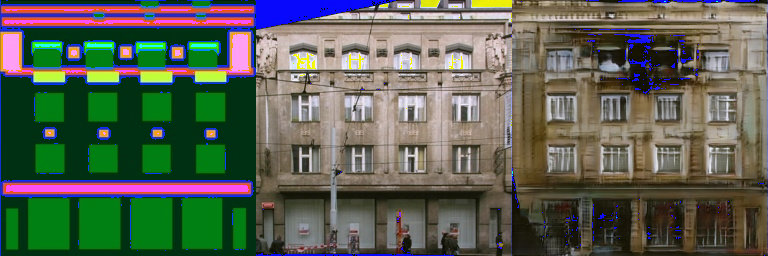

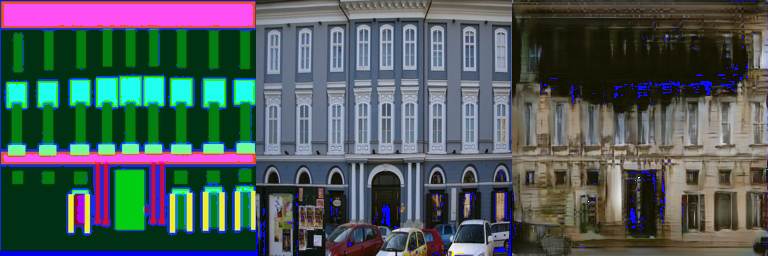

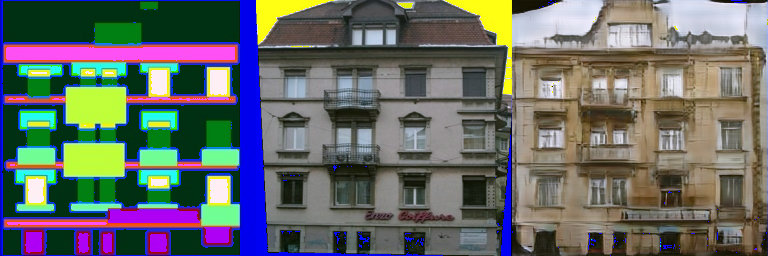

In [58]:
for i, (test_images, test_masks) in enumerate(test_dataloader):
    if i > 20:
        break
    
    test_images, test_masks = next(iter(test_dataloader))
    
    # Получим оригинальное изображение
    image = transforms.ToPILImage()(inv_normalize(test_images).squeeze(0))
    
    # Получим оригинальную маску
    mask = transforms.ToPILImage()(inv_normalize(test_masks).squeeze(0))
    
    # Получим предсказание модели
    prediction = transforms.ToPILImage()(inv_normalize(generator(test_masks.to(device))).squeeze(0))
    
    # Сводим все изображения в одно
    concatenated = get_concat_h(get_concat_h(mask, image), prediction)
    
    display(concatenated)